<a href="https://colab.research.google.com/github/aeyjeyaryan/Deep-Learning/blob/main/Feature_Extraction(TransferLearning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer learning is leveraging a working model's existing architecture and learning patterns for our own problem

ADVANTAGES::
1. Leverage an existing neural netowrk proven to work on problems similar to ours
2. Can leverage network architecture which has already learned patterns on similar data to our own

In [1]:
import tensorflow as tf

In [2]:
# Download dataset
!nvidia-smi

Mon Jun 17 01:47:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
## Downloading dataset
# 10% of food classes from food101

import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-06-17 01:47:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  88.1MB/s    in 1.8s    

2024-06-17 01:47:25 (88.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# exploring the data
import os

for dirpath, dirname, filename in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

# Creating data loaders
using imagedatagenerator class to load in our images in batches

In [5]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


# in deep learning writing things in capital means that they are some sort of hyperparameters which is going to be used somehwerre

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


# Setting up callbacks(things to run while our model trains)

Callbacks are extra functionality you can add to your models
to be performed during or after training. some of the most popular
callbacks are

* Tracking experiments with the tensorboard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training
to prevent overfitting with the EarlyStopping callback

In [6]:
# create tensorboard callback (functionized because we need to create a new one for each one)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [7]:
# Comparing two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
# Import dependencies
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
IMAGE_SHAPE +(3,)

(224, 224, 3)

In [10]:
# createmodel() function to create a model from a url

def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                        trainable=False, #freeze the learned patterns
                                        name="feature_extraction_layer",
                                        input_shape=IMAGE_SHAPE+(3,))

  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [11]:
# Create resnet model

resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [13]:
# compiling the resnetmodel
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [14]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50V2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240617-014734
Epoch 1/5
24/24 [==============================] - 26s 633ms/step - loss: 1.9008 - accuracy: 0.3680 - val_loss: 1.1792 - val_accuracy: 0.6196
Epoch 2/5
24/24 [==============================] - 12s 494ms/step - loss: 0.8712 - accuracy: 0.7347 - val_loss: 0.8603 - val_accuracy: 0.7236
Epoch 3/5
24/24 [==============================] - 12s 492ms/step - loss: 0.5982 - accuracy: 0.8200 - val_loss: 0.7405 - val_accuracy: 0.7644
Epoch 4/5
24/24 [==============================] - 12s 510ms/step - loss: 0.4572 - accuracy: 0.8733 - val_loss: 0.6971 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 12s 497ms/step - loss: 0.3670 - accuracy: 0.9107 - val_loss: 0.6799 - val_accuracy: 0.7776


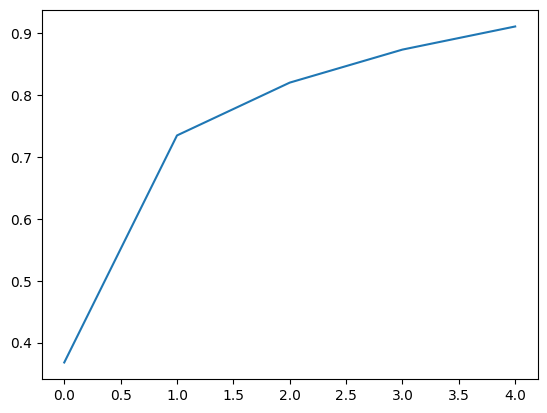

In [15]:
import matplotlib.pyplot as plt
plt.plot(resnet_history.history['accuracy'])
plt.show()

In [16]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

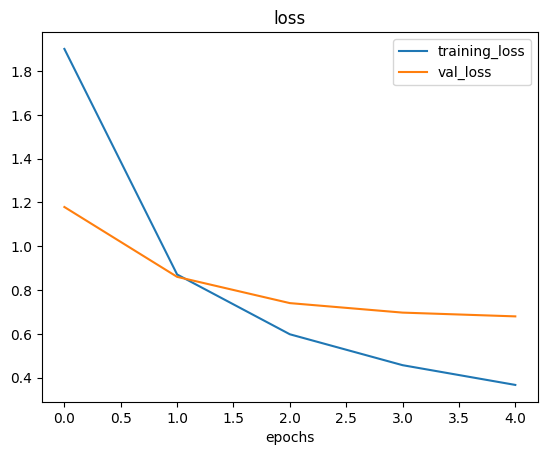

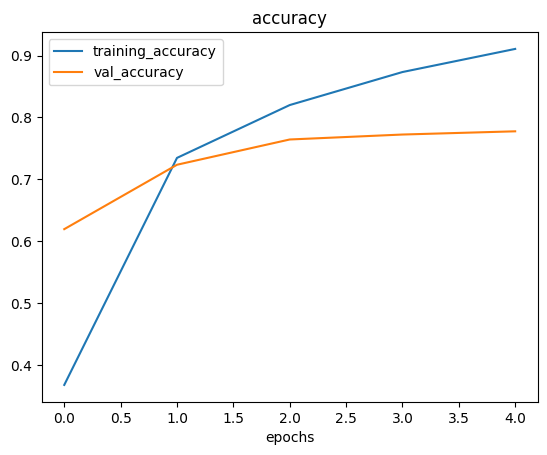

In [17]:
plot_loss_curves(resnet_history)

In [18]:
# Creating and testing efficientnetb0 tensorflow feature extractor

efficientnet_model = create_model(efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)
# compile efficientnet model
efficientnet_model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

#Fit the efficient net model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data,
                                            validation_steps=len(test_data),
                                            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                  experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20240617-014909
Epoch 1/5
24/24 [==============================] - 25s 576ms/step - loss: 1.7849 - accuracy: 0.4947 - val_loss: 1.2683 - val_accuracy: 0.7324
Epoch 2/5
24/24 [==============================] - 11s 466ms/step - loss: 1.0194 - accuracy: 0.7947 - val_loss: 0.8572 - val_accuracy: 0.8216
Epoch 3/5
24/24 [==============================] - 11s 462ms/step - loss: 0.7348 - accuracy: 0.8493 - val_loss: 0.6936 - val_accuracy: 0.8424
Epoch 4/5
24/24 [==============================] - 13s 545ms/step - loss: 0.5914 - accuracy: 0.8680 - val_loss: 0.6113 - val_accuracy: 0.8588
Epoch 5/5
24/24 [==============================] - 11s 454ms/step - loss: 0.5006 - accuracy: 0.8947 - val_loss: 0.5570 - val_accuracy: 0.8628


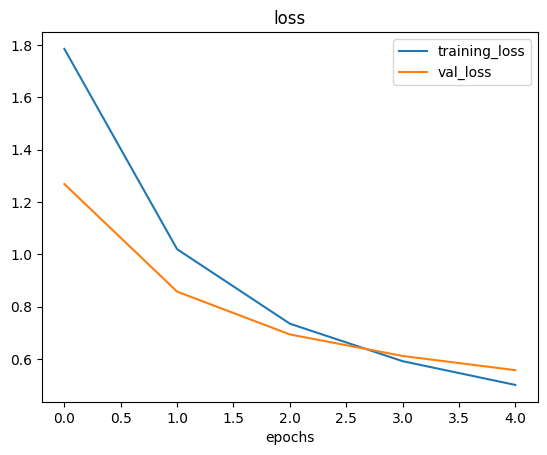

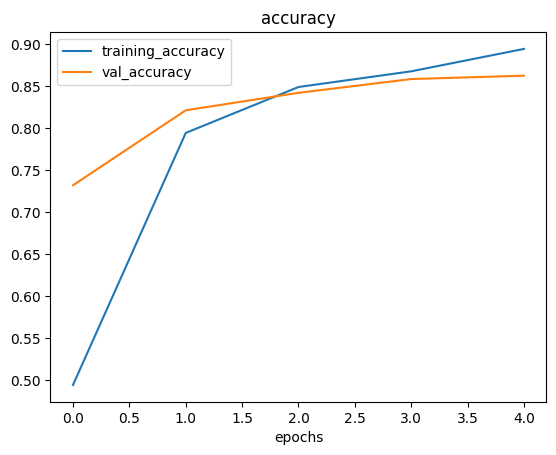

In [19]:
plot_loss_curves(efficientnet_history)

In [20]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [21]:
# calculate the number of layers (approx)
len(efficientnet_model.layers[0].weights)

309

# DIFFERENT TYPES OF TRANSFER LEARNING

* As is transfer learning - using an existing model with no changes(usisng imagenet model on 1000 imagenet classes none of our own)
* Feature extraction transfer learning - use prelearned pattern of an existing pattern (eg. effieicentnetb0 trained on testnet and adjust the outplut layer for our own problem)
* FIne tuning transfer learning - use the pre learned pattern of an existing model and fine tune many or all of the underlying layers(including new output layers)